# Session 1.1 - Univariate Linear Regression

In [52]:
%pylab inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import IPython
import platform
from sklearn import preprocessing
print ('Python version:', platform.python_version())
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sklearn.__version__)
print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Python version: 3.6.9
IPython version: 6.2.1
numpy version: 1.19.4
scikit-learn version: 0.24.2
matplotlib version: 2.1.0


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Introduction to Linear Regression
Linear regression is a very common and surprisingly useful technique for modelling the relationship between two or more variables or characteristics.  For instance, an idealised relationship between two values might take the form:

$y = b + wx$

Where $y$ is the dependent variable like (house price) or (crop yield), and $x$ is the independent or controlling variable like (distance from capital) or (amount of fertiliser).

The relationship between these two variables is a line with slope $w$ and intercept $b$.

In practice when we collect data from the real world, there is some noise in the $y$ values.  In linear regression what we aim to do is _fit_ a line to our datapoints.

## Generate a dataset using scikit-learn's utils
First we will create a dataset to try out linear regression.  Luckily scikit-learn has a module (sklearn.datasets) with both a nice selection of pre-built datasets, and various routines to generate datasets.  We can use [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) to synthesise a typical sort of regression problem.

In [53]:
from sklearn.datasets import make_regression, load_diabetes
use_diabetes = False
if use_diabetes:
    data_bunch = load_diabetes()
    X = data_bunch.data[:,2] # this is the BMI column
    y = data_bunch.target # this is the blood sugar level
else:
    X, y = make_regression(n_samples=100, n_features=1, noise=30, random_state=666)

The make_regression call produces numpy arrays, which are matrix or table-like structures.  We can check the shape using the code below.  Note that X is technically 2D, because it is a matrix of 50 rows, with one datapoint in each row (this is how sklearn "thinks" about data).  On the other hand, y for some reason is just a list of target values and so it is only 1D.  This is why X is in caps and y is lower case.


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(100, 1)
(100,)


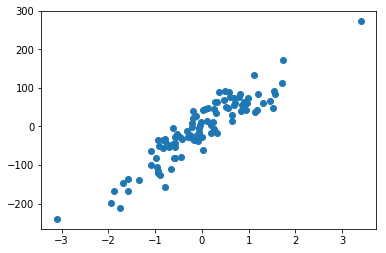

In [54]:
print(type(X), type(y))
print(X.shape)
print(y.shape)
plt.scatter(X,y)

## Partition the dataset
Next we have to split the dataset into training and test sets.  This is fairly normal - we do our machine learning on the training set, but to see how well we've done, we need to test it on some unseen data to make sure it's not "overfitting" to some peculiarities in the training set.

In fact, to do this exactly right, we should never reuse the test set (or even look at it), because doing so introduces bias to our evaluation.  However in practice data is quite a limited resource so this rule is often rather loosely followed!

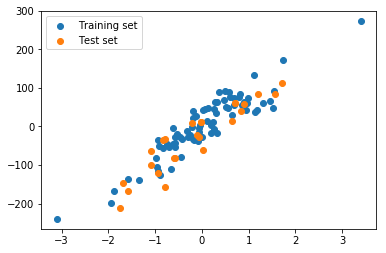

In [55]:
n = len(X)

# numpy.random.seed(666)
test_split = 0.25
test_n = int(test_split*n)
test_indices = numpy.random.randint(0,n, size=test_n)


train_indices = list(set(range(n)) - set(test_indices))

X_train  = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# convenience class to do the above...
# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

# plt.figure(figsize=(10,10)) # set figure size to 10x10 inches
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test) #it's sneaky to look at your test data!
plt.legend(labels=["Training set", "Test set"])
plt.show()

## DIY Linear Regression
Mostly we will be using scikit-learn's tools (and a few others) but let's start by rolling our own linear regression function.  Nothing fancy, it will just work for 2D (x,y) datapoints.  We will feed in the points and some configuration parameters.  The code performs gradient descent on the coefficients w and b.

The routine returns a list of predicted y-values ($\mathbf{\hat{y}}$, _aka_ y_hats), as well as the resultant values for $w$ and $b$ and the final cost value (which is just the sum of the squared differences between y_hats and y).

In [56]:
def my_linear_regression(xs,ys, n_iter=300, learning_rate_alpha=0.001):
    
    # define a local helper function to recalculate the y_hats and cost of the current line
    def recalc_predictions(xs,ys, b,w):
        cost = 0
        y_hats = []
        for x,y in zip(xs,ys):
            y_hat = b+w*x
            cost += (y_hat- y)**2
            y_hats.append(y_hat)
        return y_hats, cost
    
    N = len(xs)
    w = 0.0
    b = 0.0

    # this loop does the gradient descent proper
    for i in range(n_iter):
        y_hats, cost = recalc_predictions(xs,ys,b,w)
#         if i % 100 == 0:
#             print("cost at iteration {} = {}".format(i,cost)) # purely for display purposes
        change_w = 0.0
        change_b = 0.0    
        for x,y,y_hat in zip(xs,ys,y_hats):  
            change_w +=  2*x * (y_hat - y) # get the gradient value for each point
            change_b +=  2   * (y_hat - y) # bias doesn't depend on x, so the delta is a bit different
        change_w = change_w/N # divide these to get an average
        change_b = change_b/N
        w = w - learning_rate_alpha * change_w # here we actually adjust the coefficients/weights!
        b = b - learning_rate_alpha * change_b
    return y_hats, w, b, cost

## Write our own estimator
The _estimator_ type in Scikit-learn is one of the main classes.  It is used for both regression and classification tasks.  In this next section we will wrap the linear regression routine above into an estimator class called **MyLinearRegressor**.  This can then be used just like any estimator, via its **fit(X,y)** and **predict(X)** methods.

You will not need to remember how to write an estimator for our workshops, but it might be useful in future - feel free to use this as starter code.

For full details on writing estimators and other classes for scikit-learn, go here:
https://scikit-learn.org/stable/developers/develop.html

In [57]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import r2_score
class MyLinearRegressor(BaseEstimator):
    def __init__(self, demo_param='demo'):
         self.demo_param = demo_param

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        _,w,b,_ = my_linear_regression(X,y)
        self.w_ =  w
        self.b_ =  b
         # Return the estimator
        return self

    def predict(self, X):
        # Check if fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y_hats = self.b_ + self.w_*X
        return y_hats

    def score(self, X,y):
        check_is_fitted(self)
        X = check_array(X)
        y_hats = self.predict(X)
        return r2_score(y, y_hats)
        

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


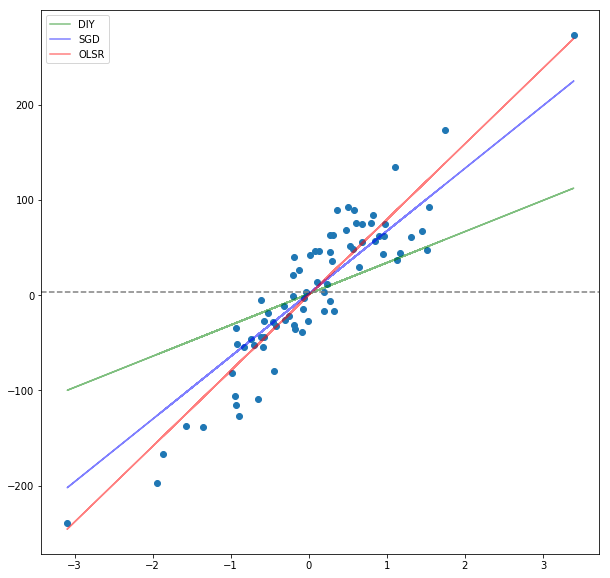

(77,)
(77,)


In [58]:
from sklearn.linear_model import LinearRegression, SGDRegressor

X_train = X_train.reshape(-1,1) # you'll find yourself doing this a lot
X_test = X_test.reshape(-1,1)

# Let's create our regressor objects
my_reg = MyLinearRegressor()
reg = LinearRegression()
sgd_reg = SGDRegressor(max_iter=10) # Stochastic Gradient Descent - can approximate LReg for very big problems

# Train and predict
my_reg.fit(X_train,y_train)
diy_y_hats = my_reg.predict(X_train).ravel()

reg.fit(X_train,y_train)
y_hats = reg.predict(X_train).ravel()

sgd_reg.fit(X_train, y_train)
sgd_y_hats = sgd_reg.predict(X_train).ravel()

# Use Matplotlib to plot dots and lines
plt.figure(figsize=(10,10))
plt.scatter(X_train, y_train)
plt.plot(X_train, diy_y_hats, color="green", label="DIY", alpha=0.5)
plt.plot(X_train, sgd_y_hats, color="blue", label="sk SGD", alpha=0.5)
plt.plot(X_train, y_hats, color="red", label="sk OLSR", alpha=0.5)
plt.axhline(numpy.mean(y_train), color="gray", linestyle="--")
plt.legend(labels=["DIY","SGD","OLSR"])
# plt.legend(labels=["Stochastic Grad. Desc.", "Ordinary Least Sqs."])
plt.show()

print(y_hats.shape)
print(diy_y_hats.shape)

Is there anything you can change to improve our line?  
Can you think of a different way to control the gradient descent?

## Basic measures of performance and goodness-of-fit

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for name, this_reg in [("Ord.Least.Sqs", reg), ("Stoch.Grad.Desc.", sgd_reg), ("DIY.Grad.Desc", my_reg)]:
    print(name.upper())
    for dataset_name, this_X, this_y in [("Training set", X_train, y_train), ("Test set", X_test, y_test)]:
        print(dataset_name)
        print("R2 is", this_reg.score(this_X, this_y))
        this_y_hats = this_reg.predict(this_X)
        print("MAE is", mean_absolute_error(this_y, this_y_hats))
        print("MSE is", mean_squared_error(this_y, this_y_hats))
        print("RMSE is", numpy.sqrt(mean_squared_error(this_y, this_y_hats)))
        print("---")

ORD.LEAST.SQS
Training set
R2 is 0.8555611130581624
MAE is 25.002821198813326
MSE is 938.8674781410706
RMSE is 30.640944472079685
---
Test set
R2 is 0.8172234492581838
MAE is 30.20533202768381
MSE is 1358.7789504289294
RMSE is 36.86161893391186
---
STOCH.GRAD.DESC.
Training set
R2 is 0.8304274836126252
MAE is 27.032328932749994
MSE is 1102.2386297310554
RMSE is 33.19997936341309
---
Test set
R2 is 0.7646629160904712
MAE is 31.496443343025604
MSE is 1749.5191509729932
RMSE is 41.82725368671715
---
DIY.GRAD.DESC
Training set
R2 is 0.5596145327608161
MAE is 40.619746283270985
MSE is 2862.5503961638974
RMSE is 53.502807367126984
---
Test set
R2 is 0.4538998695705402
MAE is 49.33644476443903
MSE is 4059.762365809211
RMSE is 63.716264531194945
---


## Plot the residuals and do an F-Test


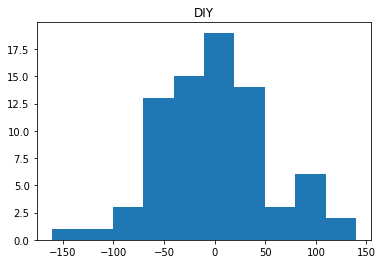

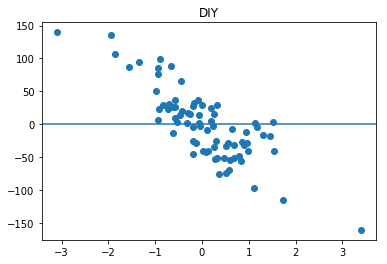

-0.8825122373889728 53.49552848897519


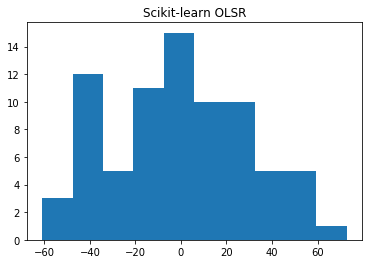

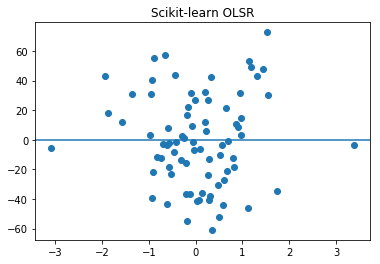

-1.4764524379430654e-15 30.640944472079685


In [60]:
get_residuals = lambda yh,y : (yh-y) # lambda expressions are a way of defining simple functions

diy_y_hats = numpy.array(diy_y_hats).ravel() # use ravel to flatten out the y_hat values

diy_residuals = get_residuals(diy_y_hats, y_train)
sk_residuals = get_residuals(y_hats, y_train)

for title,residuals in [("DIY", diy_residuals), ("Scikit-learn OLSR",sk_residuals)]:
    plt.hist(residuals)
    plt.title(title)
    plt.show()
    
    plt.scatter(X_train, residuals)
    plt.axhline(0)
    plt.title(title)
    plt.show()
    print(np.mean(residuals), np.std(residuals))    

In [51]:
#define F-test function
def f_test(residuals_1, residuals_2, nparams=2, alpha=0.95):
    SSR1 = numpy.sum(residuals_1**2)
    SSR2 = numpy.sum(residuals_2**2)
    print("Sum of Sqd residuals:")
    print("SSR1 =",SSR1, "SSR2 =",SSR2)
    f = (SSR1/SSR2)
    
    dfn = len(residuals_1)-nparams #define degrees of freedom numerator 
    dfd = len(residuals_2)-nparams #define degrees of freedom denominator 
    p = 1 - sp.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic using CDF of F distribution (from scipy)
    # small f -> large p
    print("F-statistic and corresponding p-value:", f, p)
    
    exes = numpy.linspace(0,3,30)
    peas = [1 - scipy.stats.f.cdf(x, dfn, dfd) for x in exes]
    plt.plot(exes,peas)
    plt.axhline(y = 0.95, linestyle="--", color="grey")
    plt.axhline(y = 0.05, linestyle="--", color="grey")
    plt.axvline(x=f, color="red")
    plt.show()
    # If the p-value is large (greater than α) then the first model is statistically better than the second.
    # If the p-value is small (less than 1-α) then the second model is statistically better than the first.
    if p > alpha:
        print("Model 1 is better")
    elif p < (1-alpha):
        print("Model 2 is better")
    else:
        print("F-test is inconclusive (cannot reject H0)")
    return f, p

Sum of Sqd residuals:
SSR1 = 72311.81199205463 SSR2 = 208936510.79915997
F-statistic and corresponding p-value: 0.0003460946663437119 1.0


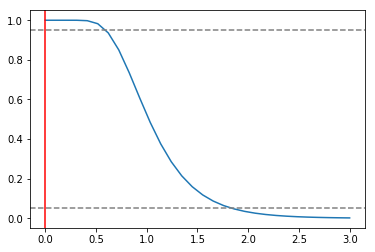

Model 1 is better
0.0003460946663437119 1.0
Sum of Sqd residuals:
SSR1 = 213450.39417608883 SSR2 = 72311.81199205463
F-statistic and corresponding p-value: 2.951805359261942 2.5011102153804643e-06


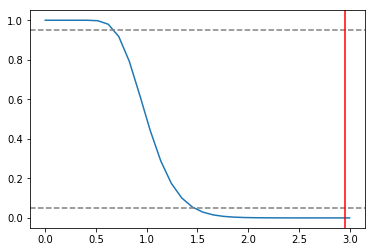

Model 2 is better
2.951805359261942 2.5011102153804643e-06


In [50]:
flat_residuals = numpy.array([(yh - numpy.mean(y_test))**2 for yh in y_hats_test])
# you can test your fit against a flat line to see if it does better than just taking the mean...
f,p = f_test(sk_residuals, flat_residuals)
print(f,p)

# Hopefully we see that our diy residuals do worse that sklearn
f,p = f_test(diy_residuals, sk_residuals)
print(f,p)

## Summary
- We generated a linear dataset (or loaded up a dataset) and manually split it into training and test sets
- We implemented linear regression with gradient descent, using our own routine
- We wrapped the routine in an estimator
- We fitted the estimator and some of sklearn's own regression estimators, and compared them
- We checked the RMSE and R2 scores
- We implemented an F-test for models with the same number of parameters
- We F-tested on the training data for significance of difference in the Sum of Sqd Residuals